In [2]:
import random
import numpy as np
import gpflow
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.analysis.compute_noise_from_budget_lib import (
    compute_noise,
)

from dp_gp.approximate_inference.dp_nat_grad_opt import NaturalGradient
from dp_gp.approximate_inference.psg_svgp import SVGP_psg
from utils import make_deterministic, plot_model

make_deterministic(1234)
plt.rcParams['font.size'] = 20

2022-08-25 19:08:38.934427: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Setup and synthetic training data generation

In [3]:
num_inducing = 50
N = 5_000  # Number of training observations
dtype = np.float64

def func(x):
    return np.sin(x * 6) + 0.3 * np.cos(x * 2) + 0.5 * np.sin(15*x)

X = np.random.rand(N, 1) * 2 - 1  # X values
Y = func(X) + 0.2 * np.random.randn(N, 1)  # Noisy Y values
X = X.astype(dtype)
Y = Y.astype(dtype)

delta = 1/N
data = (X, Y)

In [4]:
batch_size=64
train_dataset = tf.data.Dataset.from_tensor_slices(
        (X, Y)
    ).shuffle(X.shape[0])
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=True)

2022-08-25 19:08:43.199795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-25 19:08:43.773362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47190 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:21:00.0, compute capability: 7.5


## DP-SVGP with natural gradients

In [5]:
L2_CLIP = 1.0
NOISE_MULT = 2.05
epochs = 3
eps = 0.25
NOISE_MULT = compute_noise(
            n=len(X),
            batch_size=batch_size,
            target_epsilon=eps,
            epochs=epochs,
            delta=delta,
            noise_lbd=0.5)

DP-SGD with sampling rate = 1.28% and noise_multiplier = 2.4509046643488546 iterated over 235 steps satisfies differential privacy with eps = 0.25 and delta = 0.0002.


In [6]:
Z_init = np.random.uniform(-1, 1, size=(num_inducing, 1))
nat_model = SVGP_psg(
    kernel=gpflow.kernels.SquaredExponential(),
    likelihood=gpflow.likelihoods.Gaussian(),
    inducing_variable=Z_init,
    num_data=N
)
nat_model.kernel.lengthscales.assign(0.15)
nat_model.likelihood.variance.assign(0.05)
nat_model.kernel.variance.assign(0.8)

gpflow.set_trainable(nat_model.q_mu, False)
gpflow.set_trainable(nat_model.q_sqrt, False)
gpflow.set_trainable(nat_model.inducing_variable.Z, False)

variational_params = [(nat_model.q_mu, nat_model.q_sqrt)]
natgrad_opt = NaturalGradient(gamma=0.2, l2_norm_clip=L2_CLIP, noise_multiplier=NOISE_MULT)
nat_model

name,class,transform,prior,trainable,shape,dtype,value
SVGP_psg.kernel.variance,Parameter,Softplus,,True,(),float64,0.8000000000000002
SVGP_psg.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.15
SVGP_psg.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.05000000000000001
SVGP_psg.inducing_variable.Z,Parameter,Identity,,False,"(50, 1)",float64,[[-0.06232153...
SVGP_psg.q_mu,Parameter,Identity,,False,"(50, 1)",float64,[[0....
SVGP_psg.q_sqrt,Parameter,FillTriangular,,False,"(1, 50, 50)",float64,"[[[1., 0., 0...."


In [7]:
from dp_gp.approximate_inference.common_train_logic import optimization_step_natgrad
print("before training:", tf.reduce_mean(nat_model.elbo(data, scale_elbo=True)).numpy())

with tqdm(total=epochs * len(train_dataset)) as pbar:
  for e in range(epochs):
    for i, (x_batch, y_batch) in enumerate(train_dataset):
      batch_loss, _ = optimization_step_natgrad(nat_model, (x_batch, y_batch), natgrad_opt, variational_params)
      pbar.update()
      if i % 5 == 0:
        elbo = tf.math.reduce_mean(nat_model.elbo(data))
        elbo_scaled = tf.math.reduce_mean(nat_model.elbo(data, scale_elbo=True))
        pbar.set_description(f"loss: {batch_loss:.3f} ELBO: {elbo.numpy():.3f}, ELBO (scaled): {elbo_scaled.numpy():.3f}")

2022-08-25 19:05:23.057817: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55fab4342bb0


before training: -74211.08427773872


loss: 1151.723 ELBO: -14.367, ELBO (scaled): -71636.861:   0%|          | 1/234 [00:00<02:14,  1.74it/s]

loss: 126.430 ELBO: -26.031, ELBO (scaled): -6245.307: 100%|██████████| 234/234 [01:59<00:00,  1.95it/s] 


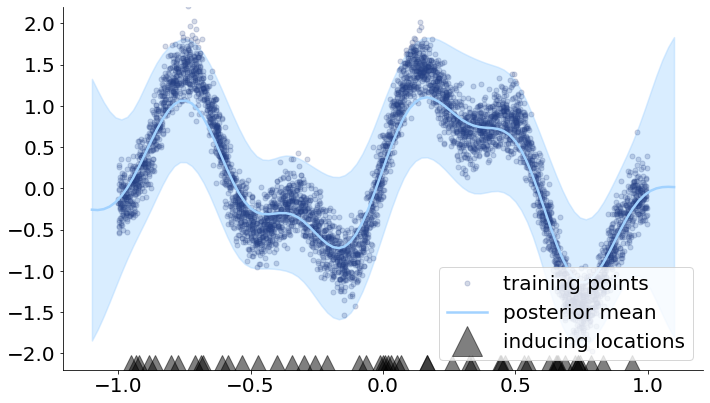

In [8]:
plot_model(nat_model, data)
plt.savefig("./figures/natgrad/natgrad_posterior.pdf")

In [9]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=N,
                                              batch_size=batch_size,
                                              noise_multiplier=NOISE_MULT,
                                              epochs=epochs,
                                              delta=delta)

DP-SGD with sampling rate = 1.28% and noise_multiplier = 2.4509046643488546 iterated over 235 steps satisfies differential privacy with eps = 0.25 and delta = 0.0002.
The optimal RDP order is 35.0.


(0.250000000000151, 35.0)

## DP-SVGP with ordinary gradients

In [5]:
L2_CLIP = 1.0
eps=0.5
epochs = 60
NOISE_MULT = compute_noise(
            n=len(X),
            batch_size=batch_size,
            target_epsilon=eps,
            epochs=epochs,
            delta=delta,
            noise_lbd=0.5)

DP-SGD with sampling rate = 1.28% and noise_multiplier = 5.481841679300487 iterated over 4688 steps satisfies differential privacy with eps = 0.5 and delta = 0.0002.


In [7]:
from dp_gp.approximate_inference.dp_gd_optimizer import VectorizedDPKerasAdamOptimizer 

Z_init = np.random.uniform(-1, 1, size=(num_inducing, 1))
model = SVGP_psg(
    kernel=gpflow.kernels.SquaredExponential(),
    likelihood=gpflow.likelihoods.Gaussian(),
    inducing_variable=Z_init,
    num_data=N
)
model.kernel.lengthscales.assign(0.15)
model.likelihood.variance.assign(0.05)
model.kernel.variance.assign(0.8)

gpflow.set_trainable(model.inducing_variable.Z, False)

variational_params = [(model.q_mu, model.q_sqrt)]
opt = VectorizedDPKerasAdamOptimizer(learning_rate=0.01, l2_norm_clip=L2_CLIP, noise_multiplier=NOISE_MULT)
model

name,class,transform,prior,trainable,shape,dtype,value
SVGP_psg.kernel.variance,Parameter,Softplus,,True,(),float64,0.8000000000000002
SVGP_psg.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.15
SVGP_psg.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.05000000000000001
SVGP_psg.inducing_variable.Z,Parameter,Identity,,False,"(50, 1)",float64,[[-0.06232153...
SVGP_psg.q_mu,Parameter,Identity,,True,"(50, 1)",float64,[[0....
SVGP_psg.q_sqrt,Parameter,FillTriangular,,True,"(1, 50, 50)",float64,"[[[1., 0., 0...."


In [9]:
from dp_gp.approximate_inference.common_train_logic import optimization_step
print("before training:", tf.reduce_mean(model.elbo(data, scale_elbo=True)).numpy())
tf_optim_step = tf.function(optimization_step)

with tqdm(total=epochs * len(train_dataset)) as pbar:
  for e in range(epochs):
    for i, (x_batch, y_batch) in enumerate(train_dataset):
      batch_loss, _ = tf_optim_step(model, (x_batch, y_batch), opt)
      pbar.update()
      if i % 5 == 0:
        elbo = tf.math.reduce_mean(model.elbo(data))
        elbo_scaled = tf.math.reduce_mean(model.elbo(data, scale_elbo=True))
        pbar.set_description(f"loss: {batch_loss:.3f} ELBO: {elbo.numpy():.3f}, ELBO (scaled): {elbo_scaled.numpy():.3f}")

2022-08-25 19:09:17.045397: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x563c36620d00


before training: -74211.08427773872


loss: 135.966 ELBO: -115.190, ELBO (scaled): -1185.090: 100%|██████████| 4680/4680 [01:38<00:00, 47.74it/s]


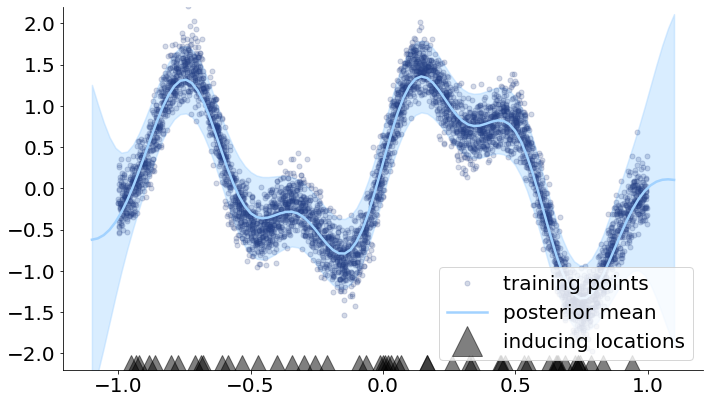

In [10]:
plot_model(model, data)
plt.savefig("./figures/natgrad/dpsvgp_posterior.pdf")

In [11]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=N,
                                              batch_size=batch_size,
                                              noise_multiplier=NOISE_MULT,
                                              epochs=epochs,
                                              delta=delta)

DP-SGD with sampling rate = 1.28% and noise_multiplier = 5.481841679300487 iterated over 4688 steps satisfies differential privacy with eps = 0.5 and delta = 0.0002.
The optimal RDP order is 21.0.


(0.49999999999997374, 21.0)